In [176]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score, precision_score
#Can be very helpful to notice any imbalance in classes
from collections import Counter 
import sweetviz as sv
from matplotlib import pyplot as plt
from sklearn import tree

In this part, we try to connect to PSQL

In [15]:
#Sourced from https://www.postgresqltutorial.com/postgresql-python/connect/
def config(filename='database.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [16]:
#Get the configuration file as a python dictionary
cfg = config()

In [41]:
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Look's like it was a success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Look's like it was a success


In [42]:
try:
    #Lets get our data 
    cursor.execute('''SELECT p.acquisition_group, p.gender, p.age_group, d.month, w.daily_high_temperature, s.title, f.resolved,
                    f.unresolved, f.fatal, m.retail_and_recreation::INTEGER
                    FROM covid19_tracking_fact_table f
                    INNER JOIN onset_date_dimension d
                    ON d.date_surrogate_key = f.onset_date_surrogate_key
                    INNER JOIN patient_dimension p 
                    ON p.patient_surrogate_key = f.patient_surrogate_key
                    INNER JOIN weather_dimension w 
                    ON w.weather_surrogate_key = f.weather_surrogate_key
                    INNER JOIN special_measures_dimension s
                    ON s.special_measures_surrogate_key = f.special_measures_surrogate_key
                    INNER JOIN mobility_dimension m 
                    ON m.mobility_surrogate_key = f.mobility_surrogate_key
                    '''
                  )

    #Get the complete result set. It will be a list of tuples where each tuple is a row from the result set
    result_list = cursor.fetchall()
        
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

In [43]:
#Ensure to run this cell at the end of all your experiments to close all connections
cursor.close()
conn.close()

Let's prepare the DataFrame.

In [141]:
#Now, 
result_df = pd.DataFrame(result_list, columns=['acquisition_group',
                                              'gender',
                                              'age_group',
                                              'month',
                                              'daily_high_temperature',
                                              'special_measure',
                                               'is_resolved',
                                              'is_unresolved',
                                              'is_fatal',
                                              'retail_and_recreation_mobility'])

Let's see how the data looks like

In [135]:
result_df.head()

,gender,month,special_measure,is_resolved,is_unresolved,is_fatal,retail_and_recreation_mobility
0,MALE,7,Stage 2,True,False,False,-18
1,MALE,7,Stage 2,True,False,False,-24
2,FEMALE,7,Stage 2,True,False,False,-22
3,MALE,7,Stage 2,True,False,False,-48
4,FEMALE,7,Stage 2,True,False,False,-24


In [146]:
my_report = sv.analyze(result_df)


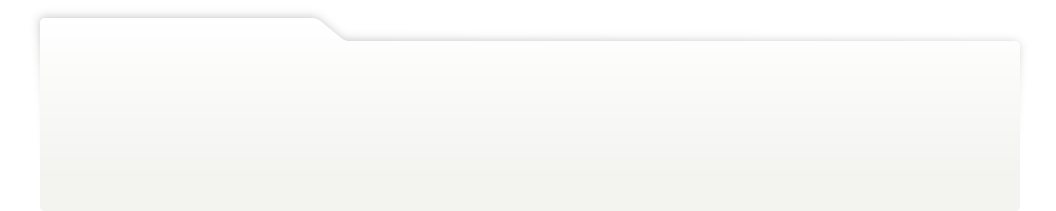
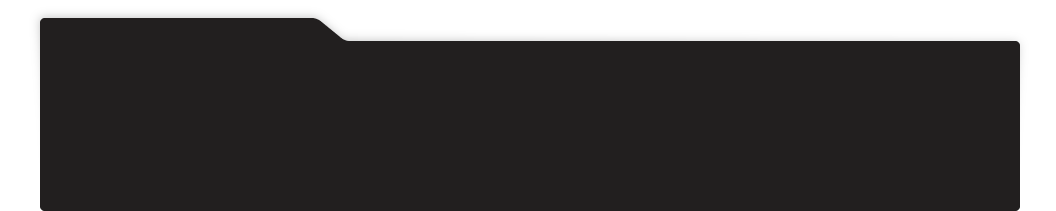
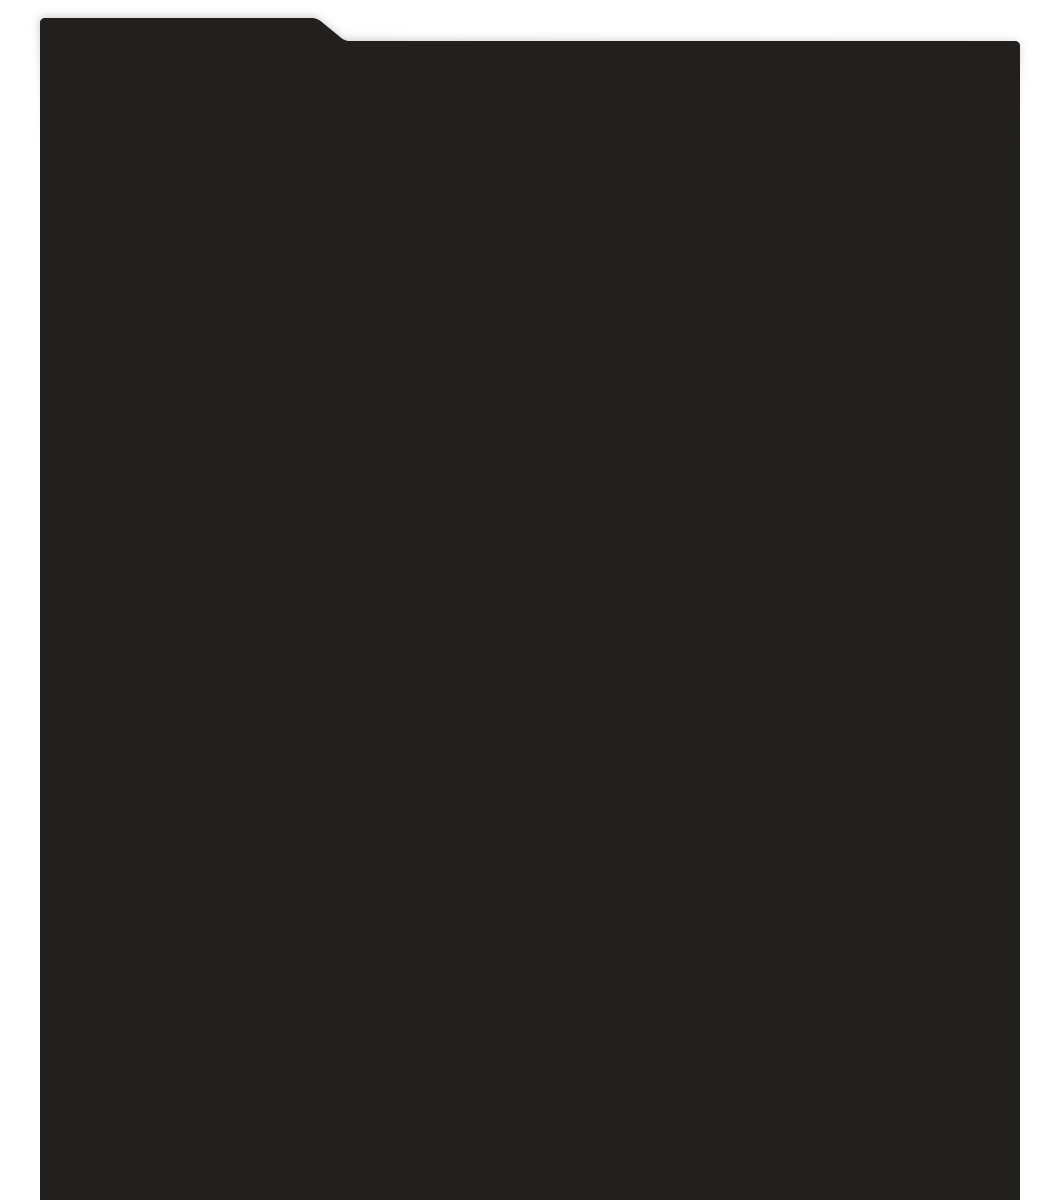
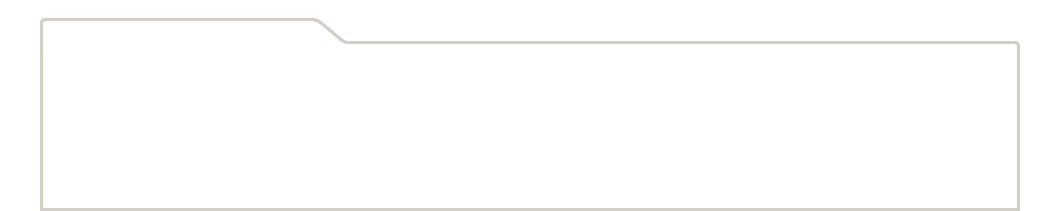
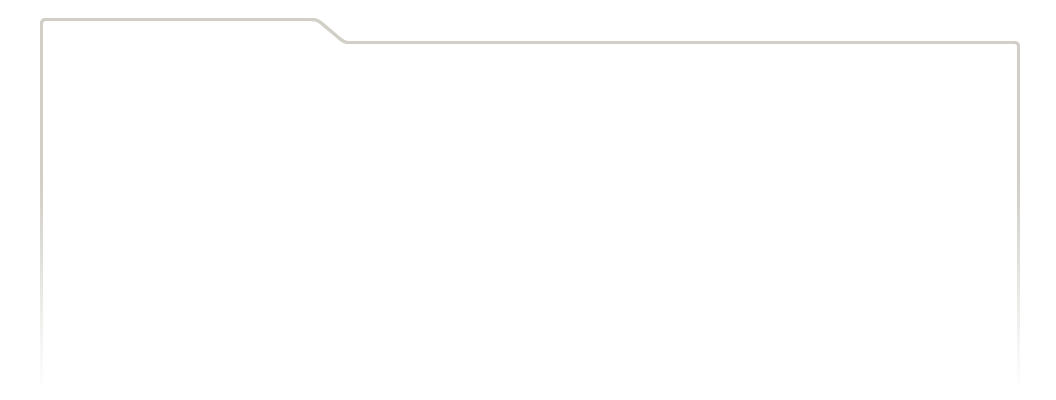
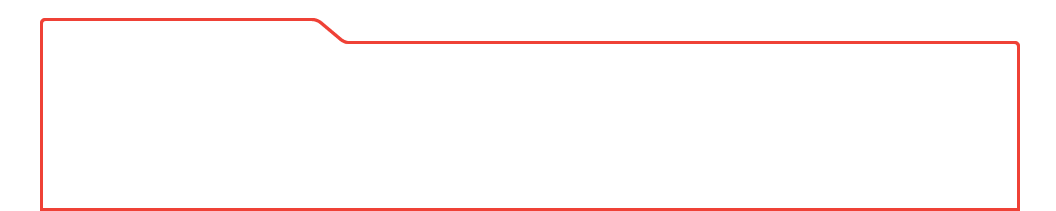
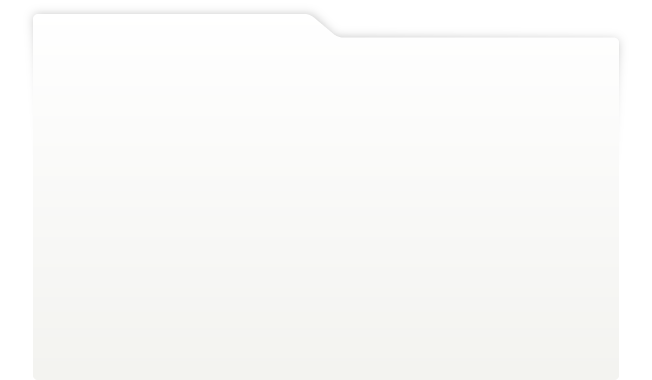
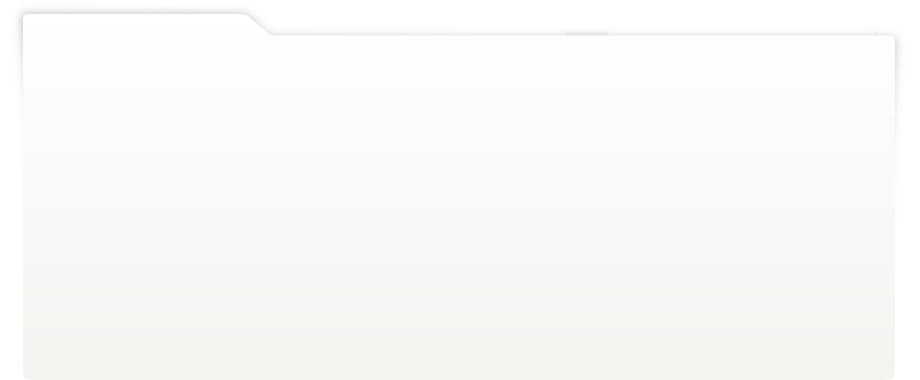
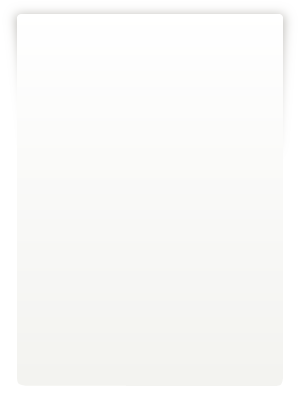
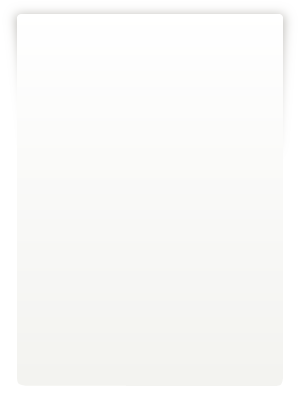
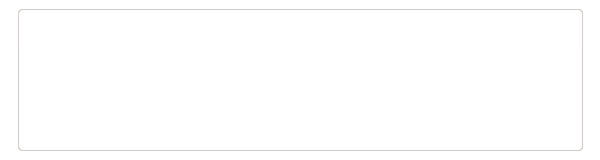
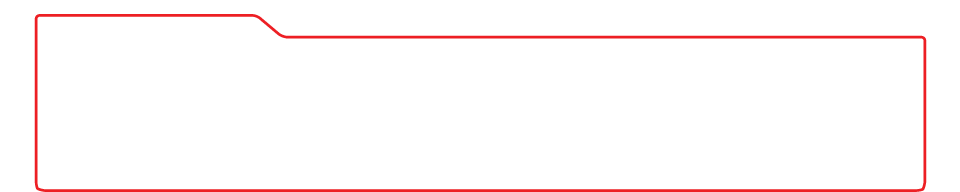
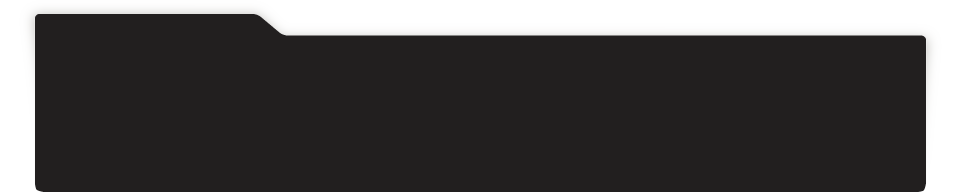
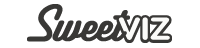
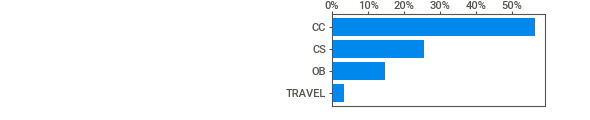
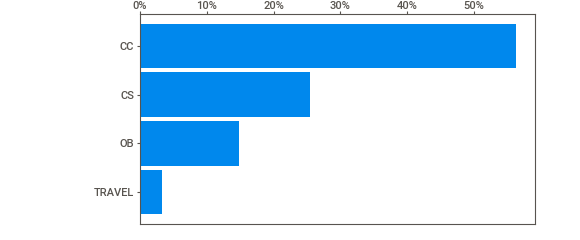
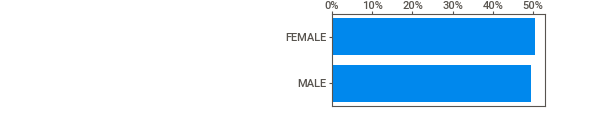
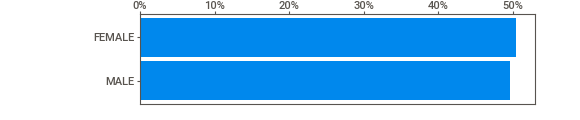
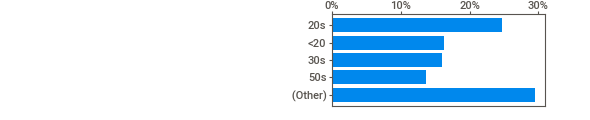
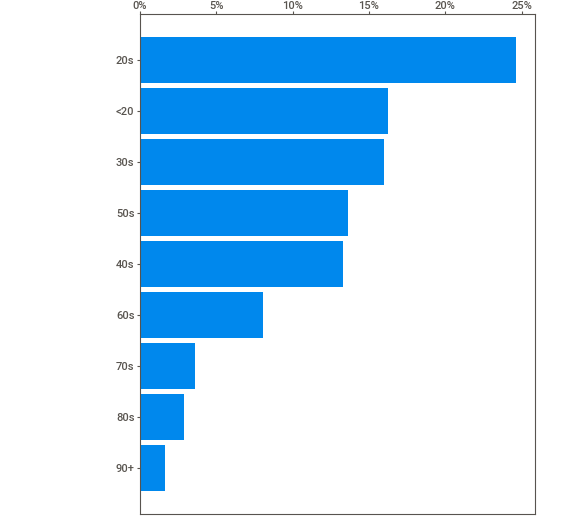
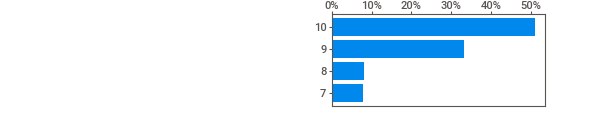
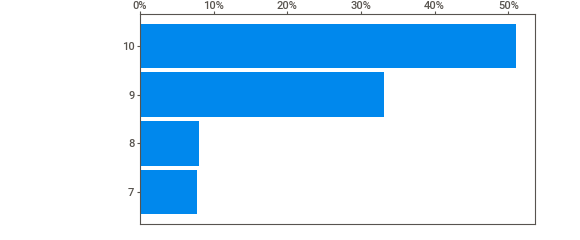
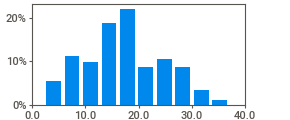
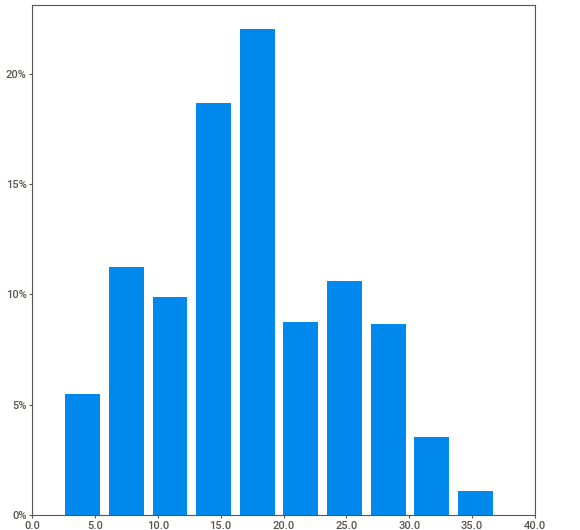
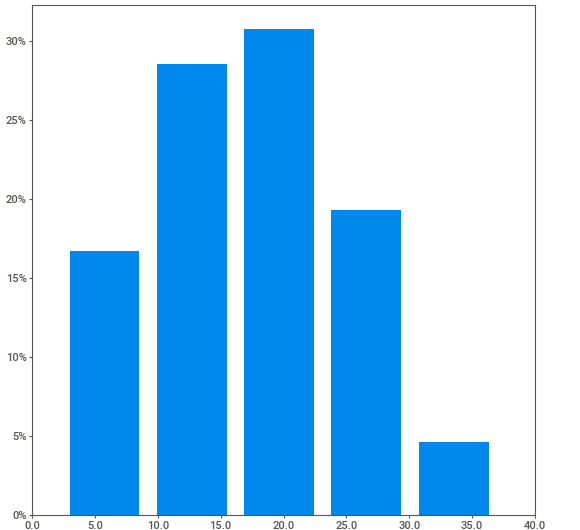
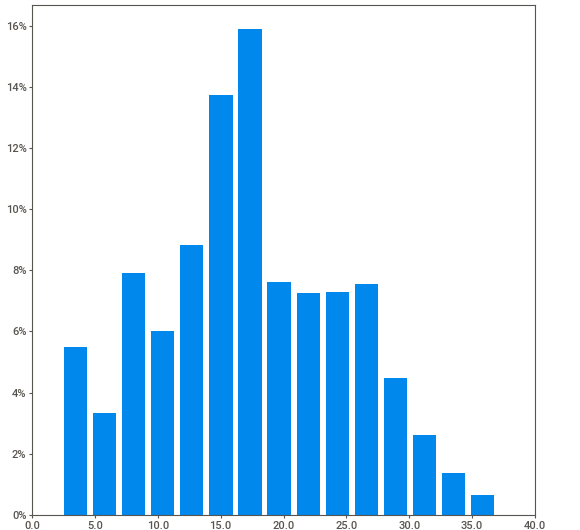
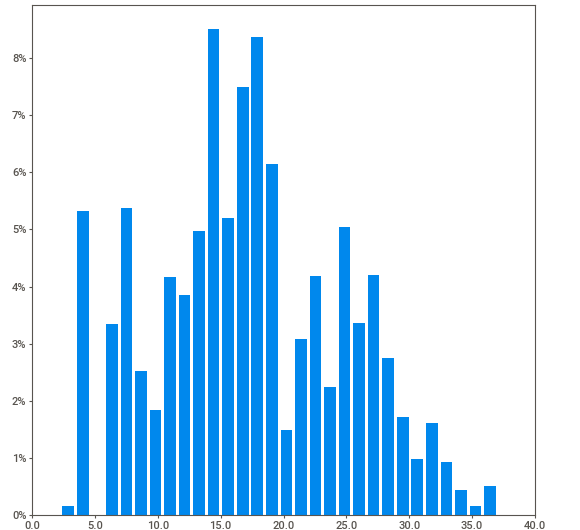
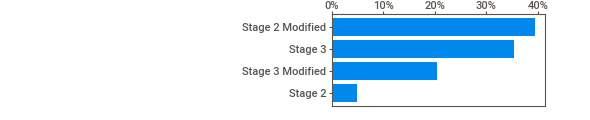
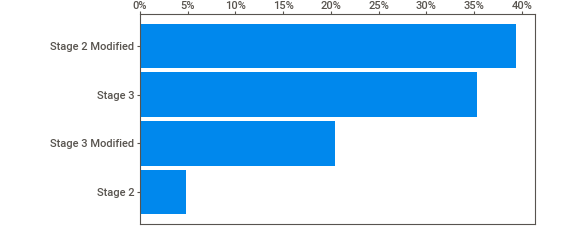
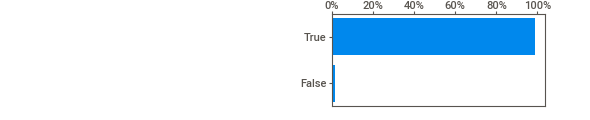
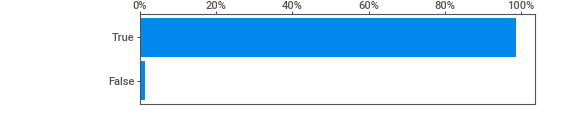
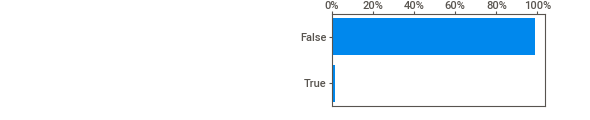
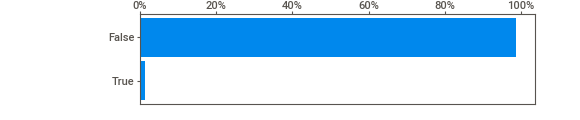
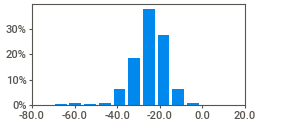
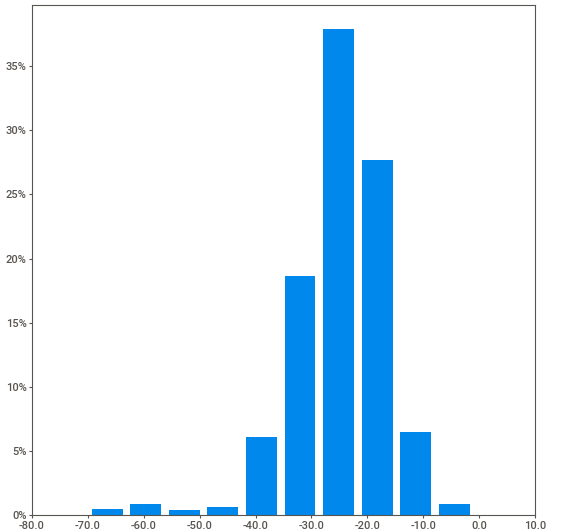
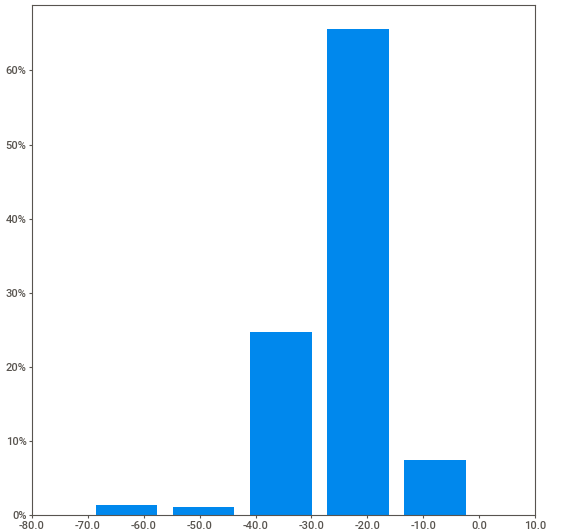
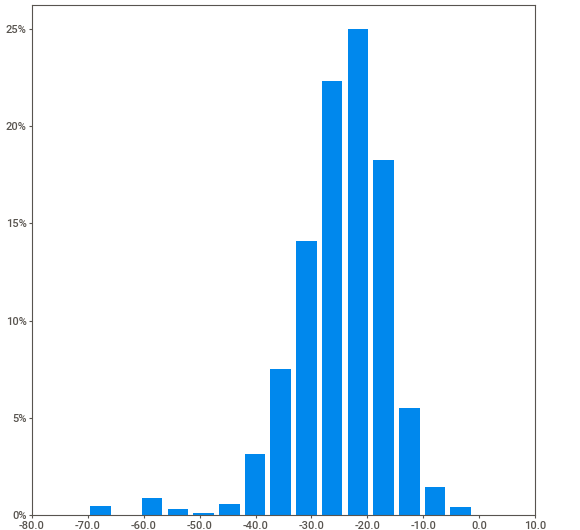
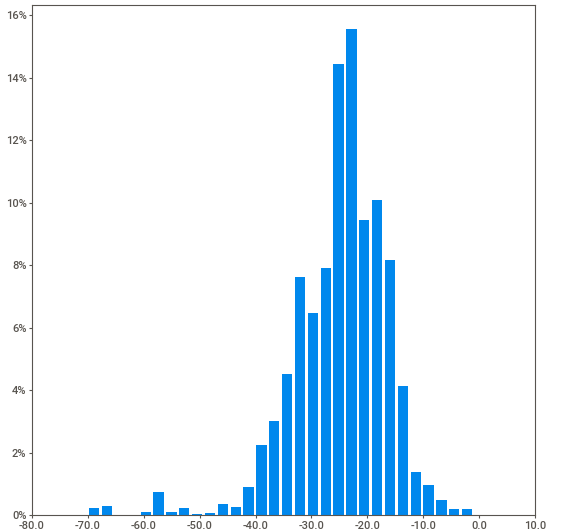
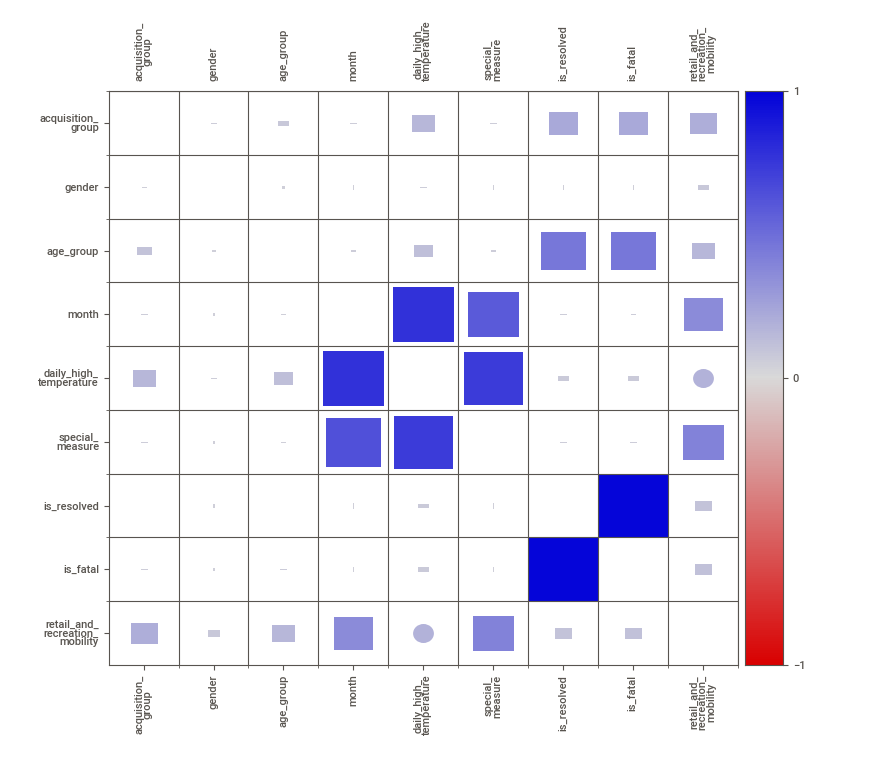
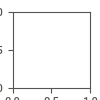

In [147]:
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

In [142]:
result_df.columns

Index(['acquisition_group', 'gender', 'age_group', 'month',
       'daily_high_temperature', 'special_measure', 'is_resolved',
       'is_unresolved', 'is_fatal', 'retail_and_recreation_mobility'],
      dtype='object')

In [144]:
result_df.drop(result_df[result_df['acquisition_group']=='MISSING INFORMATION'].index, inplace = True)
result_df.drop(result_df[ result_df['age_group']=='UNKNOWN'].index, inplace = True)
result_df.drop(result_df[ result_df['gender'].isin(['UNSPECIFIED', 'GENDER DIVERSE'])].index, inplace = True)
result_df.drop('is_unresolved', axis = 1, inplace = True)

In [148]:
result_df.acquisition_group.value_counts()

CC        16745
CS         7579
OB         4402
TRAVEL      997
Name: acquisition_group, dtype: int64

In [149]:
df = result_df.drop_duplicates()

In [151]:
df.acquisition_group.value_counts()

CC        5223
CS        3759
OB        2593
TRAVEL     883
Name: acquisition_group, dtype: int64

In [152]:
df.age_group.value_counts()

20s    2234
30s    1941
50s    1801
40s    1770
<20    1655
60s    1386
70s     800
80s     566
90+     305
Name: age_group, dtype: int64

Both labels are highly imbalanced! We need to make sure to consider this when we test our models.

In [153]:
new_result = pd.get_dummies(df, columns=['acquisition_group', 'gender', 'age_group', 'month','special_measure'])

In [154]:
new_result

,daily_high_temperature,is_resolved,is_fatal,retail_and_recreation_mobility,acquisition_group_CC,acquisition_group_CS,acquisition_group_OB,acquisition_group_TRAVEL,gender_FEMALE,gender_MALE,...,age_group_90+,age_group_<20,month_7,month_8,month_9,month_10,special_measure_Stage 2,special_measure_Stage 2 Modified,special_measure_Stage 3,special_measure_Stage 3 Modified
0,32.0,True,False,-18,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,37.0,True,False,-24,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,34.5,True,False,-22,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,32.5,True,False,-48,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,37.0,True,False,-24,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,28.5,False,True,-33,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,0,0
36811,30.5,False,True,-36,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
36819,11.0,True,False,-34,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
36824,15.5,False,True,-38,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0


In [162]:
y = new_result.iloc[:,5:9]
y

,acquisition_group_CS,acquisition_group_OB,acquisition_group_TRAVEL,gender_FEMALE
0,0,0,0,0
1,0,0,0,0
2,0,0,0,1
3,0,1,0,0
4,1,0,0,1
...,...,...,...,...
36809,0,1,0,0
36811,0,0,0,0
36819,0,0,0,1
36824,0,1,0,1


We are done with pre-processing of our data. Next, we need to devide our data to training and testing sets.

In [163]:
X = new_result.drop(new_result.iloc[:,5:9], axis = 1)
X

,daily_high_temperature,is_resolved,is_fatal,retail_and_recreation_mobility,acquisition_group_CC,gender_MALE,age_group_20s,age_group_30s,age_group_40s,age_group_50s,...,age_group_90+,age_group_<20,month_7,month_8,month_9,month_10,special_measure_Stage 2,special_measure_Stage 2 Modified,special_measure_Stage 3,special_measure_Stage 3 Modified
0,32.0,True,False,-18,1,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1,37.0,True,False,-24,1,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,34.5,True,False,-22,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,32.5,True,False,-48,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,37.0,True,False,-24,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36809,28.5,False,True,-33,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
36811,30.5,False,True,-36,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
36819,11.0,True,False,-34,1,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
36824,15.5,False,True,-38,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [166]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [167]:
y_pred = dt.predict(X_test)
recall = recall_score(y_pred, y_test, average='micro') * 100
precision = precision_score(y_pred, y_test, average='micro') * 100
print("Recall of Decision Tree {:.2f} %".format(recall))
print("Precision of Decision Tree {:.2f} %".format(precision))

Recall of Decision Tree 67.30 %
Precision of Decision Tree 61.35 %


In [169]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

0.5810593900481541

|--- feature_5 <= 0.50
|   |--- feature_4 <= 0.50
|   |   |--- feature_13 <= 0.50
|   |   |   |--- feature_12 <= 0.50
|   |   |   |   |--- feature_21 <= 0.50
|   |   |   |   |   |--- feature_3 <= -27.50
|   |   |   |   |   |   |--- feature_1 <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_1 >  0.50
|   |   |   |   |   |   |   |--- feature_6 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_3 <= -41.50
|   |   |   |   |   |   |   |   |   |--- feature_3 <= -58.50
|   |   |   |   |   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_3 >  -58.50
|   |   |   |   |   |   |   |   |   |   |--- feature_11 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |